In [293]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy import signal

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs
from parula import cm as parula_cm

In [195]:
factor = 15
dataset = inputs.Sim1DFeederAndCache(
    steps_in_phases=[0,15000,0],
    left_right_stay_prob=[4,1,1], expansion=1,
    num_spatial_states=16*factor,
    visit_length=1,
    feeder_states = np.arange(8*factor, 9*factor),
    cache_states=[]
    )

# Sanity Check Plots

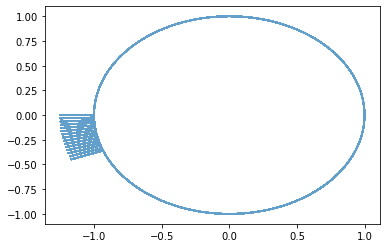

In [196]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

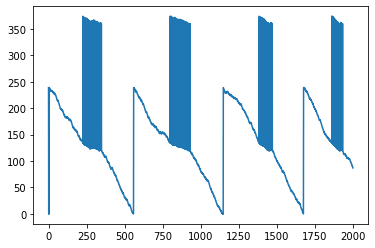

In [197]:
plt.figure();
plt.plot(dataset.state_inputs[:2000])
plt.show()

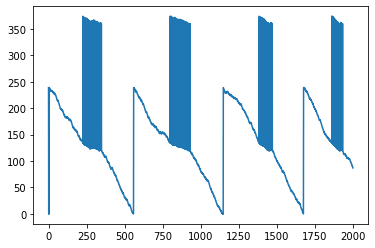

In [198]:
plt.figure();
plt.plot(dataset.expanded_state_inputs[:2000])
plt.show()

# Run through model

In [199]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [200]:
outputs = []
T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
for step in np.arange(1, dataset.num_steps):
    prev_state = dataset.expanded_state_inputs[step-1]
    curr_state = dataset.expanded_state_inputs[step]
    T_counts[prev_state, curr_state] +=1

# Parameters

In [325]:
gamma = 0.99
plot_feeder_cells = True

# Plot raw M

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_10832/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


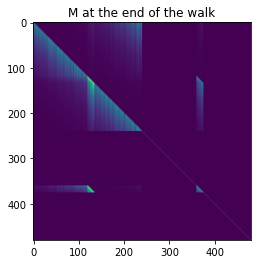

In [326]:
M = get_M(normalize(T_counts), gamma)
plt.figure()
plt.imshow(M)
plt.title('M at the end of the walk')
plt.show()

# Plot aliased M

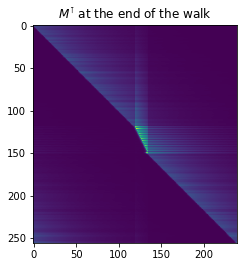

In [327]:
if plot_feeder_cells:
    feeder_states = np.concatenate([
        np.arange(f*dataset.expansion, (f+1)*dataset.expansion) for f in dataset.feeder_states
        ]) + (dataset.num_spatial_states*dataset.expansion)
    interleaved_feeder_states = list(chain(*zip(dataset.feeder_states, feeder_states)))
    feeder_states = interleaved_feeder_states
else:
    feeder_states = dataset.feeder_states
pre_feeder_state = (dataset.feeder_states[0])*dataset.expansion - 1
post_feeder_state = (dataset.feeder_states[-1])*dataset.expansion - 1

# Drop unused non-spatial columns
M = M[:, np.concatenate((
    np.arange(pre_feeder_state),
    feeder_states,
    np.arange(post_feeder_state, dataset.num_spatial_states)
    ))]

# Sum matrix across aliased spatial states
_aliased_M = M[:dataset.num_spatial_states*dataset.expansion]
_aliased_M += M[dataset.num_spatial_states*dataset.expansion:]

# Squash expansion if necessary
if dataset.expansion > 1:
    aliased_M = np.zeros((dataset.num_spatial_states, _aliased_M.shape[1]))
    for i in range(dataset.num_spatial_states):
        for j in range(_aliased_M.shape[1]):
            aliased_M[i,j] = np.mean(
                _aliased_M[np.arange(i*dataset.expansion, (i+1)*dataset.expansion), j]
                )
else:
    aliased_M = _aliased_M

plt.figure()
plt.imshow(aliased_M.T)
plt.title('$M^\intercal$ at the end of the walk')
plt.show()

# Process and plot processed M

In [328]:
def noise_vec(arr):
    return np.random.poisson(np.percentile(arr, 99)/2., size=arr.size)

In [329]:
def add_noise(X):
    """ Add Poisson noise with 1/4 scale of max for each row. """
    
    new_X = []
    X = X.copy()
    for x in X:
        x += noise_vec(x)

        new_X.append(x)
    return np.array(new_X)

In [330]:
def hanning_smooth(X):
    """ Smooth each row with Hanning window. """
    
    new_X = []
    X = X.copy()
    win_ratio = 7/60.
    win_size = int(win_ratio*X.shape[1])
    win = signal.windows.hann(win_size)
    win /= np.sum(win)
    for x in X:
        conv_x = signal.convolve(x, win, mode='same')
        new_X.append(conv_x)
    return np.array(new_X)

In [331]:
def remove_insig(X):
    """ Remove any row where peak is < 3 s.d. above mean"""
    
    new_X = []
    X = X.copy()
    for x in X:
        if x.max() < np.mean(x) + 2.5*np.std(x):
            continue
        new_X.append(x)
    return np.array(new_X)

In [332]:
def z_score(X):
    """ z-scores each row """
    
    X = X.copy()
    X -= np.mean(X, axis=1)[:, np.newaxis]
    X /= np.std(X, axis=1)[:, np.newaxis]
    return X

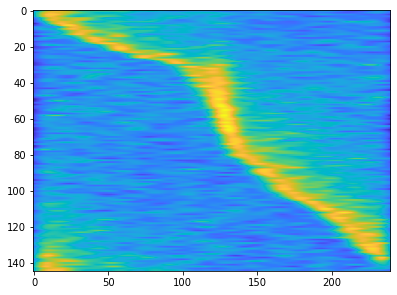

In [334]:
popln_activity = aliased_M.T.copy()
popln_activity = add_noise(popln_activity)
popln_activity = hanning_smooth(popln_activity)
popln_activity = remove_insig(popln_activity)
popln_activity = z_score(popln_activity)

plt.figure(figsize=(6.4, 4.8))
plt.imshow(popln_activity, cmap=parula_cm, aspect='auto')
plt.savefig("feeder.png", dpi=300)
plt.show()

In [336]:
popln_activity.shape

(145, 240)

In [337]:
from scipy.io import savemat

In [338]:
savemat('activity_aligned_to_feeder.mat', {'data':popln_activity}) # (neurons, location)

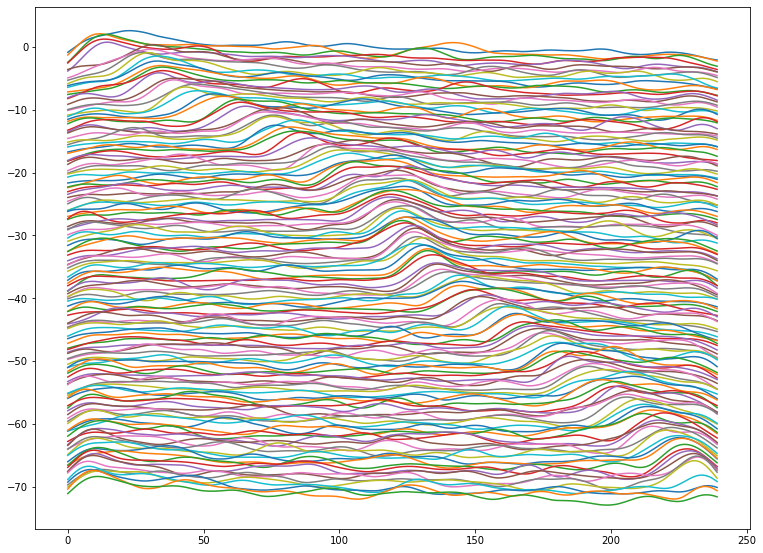

In [324]:
plt_idx = 0
plt_step = -0.5 #-1.
plt.figure(figsize=(6.4*2, 4.8*2))
for ff in popln_activity:
    plt.plot(ff + plt_idx)
    plt_idx += plt_step
plt.show()